# Occupation-Skill Recommendation System

This recommender tool allows graduates to input the skills they have acquired from their degree programs and receive a set of recommended occupations that suit their skills. This project aims to enhance graduate outcomes by providing them with knowledge of relevant job opportunities that align with their skill sets, thereby facilitating their job search process. 

To use this notebook, ensure to 'Run All' code until a pop-up box appear. Input your relevant skill sets in the box given and press 'Enter' to obtain result.

**Note that: It is best to input as much skills as possible to obtain a more accurate result**

### Importing Libraries and Retrieving Files

In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pandasql as psql
import tkinter as tk

from pandasql import sqldf
from IPython.display import clear_output
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer, util
import warnings
import requests

warnings.filterwarnings("ignore")
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nkhai\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nkhai\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nkhai\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [2]:
# Read and transform data ro pandas Dataframe
skills = pd.read_csv(r'https://raw.githubusercontent.com/nkkhairina/UCL_DissertationProject/main/skills_en.csv', dtype=object)
occupations = pd.read_csv(r'https://raw.githubusercontent.com/nkkhairina/UCL_DissertationProject/main/occupations_en.csv', dtype=object)
occupationSkillRelations = pd.read_csv(r'https://raw.githubusercontent.com/nkkhairina/UCL_DissertationProject/main/occupationSkillRelations_en.csv', dtype=object)
ISCOGroups = pd.read_csv('https://raw.githubusercontent.com/nkkhairina/UCL_DissertationProject/main/ISCOGroups_en.csv', dtype=object)

# Load stop words from file
response = requests.get('https://raw.githubusercontent.com/kkhairina/UCL_DissertationProject/main/stopwords.txt')
stop_words = response.text.splitlines()

## Data Pre-Processing

This pre-processing step helps to match ESCO's skills with it's relevant ESCO occupations. By left joining tables, this could help to replace URIs from original table into a proper occupation title which provides us a better understanding of the Occupation and Skill relationship. 

Other pre-processing steps include grouping and aggregating the skills into a single list of dataframe which is separated by comma for one occupation respectively. List is then sorted in alphabetical order. 

There is also a function essentially encapsulates the splitting, sorting, and joining logic shown in the earlier steps, however it is applied to the user input skill sets.

In [3]:
# Merge data into one single dataframe
occ_skill = sqldf('''
    select
        oc.preferredLabel as Occupation,
        sk.preferredLabel as Skills
    from occupationSkillRelations osr
    left join occupations oc on osr.occupationUri = oc.conceptUri
    left join skills sk on osr.skillUri = sk.conceptUri
''')

data = occ_skill.groupby('Occupation').agg(Skills = ('Skills', list)).reset_index()
data["Skills"] = data["Skills"].apply(lambda x: ', '.join([str(i) for i in x]))

data['Skills'] = data['Skills'].str.split(', ')

# Sort the lists in alphabetical order
data['Skills'] = data['Skills'].apply(sorted)

# Join the sorted lists back into comma-separated strings
data['Skills'] = data['Skills'].apply(', '.join)

def sort_list(input_str):
    # Split the input string into a list using commas as the delimiter
    input_list = input_str.split(',')
    # Sort the list in alphabetical order
    sorted_list = sorted(input_list)
    # Join the sorted list back into a string with commas
    sorted_str = ', '.join(sorted_list)
    return sorted_str

The code below performs text preprocessing on the 'Skills' column of the data DataFrame by converting each skill into its base or root form using lemmatization. It first maps each word to its appropriate part of speech (POS) and then lemmatizes it accordingly, ensuring consistency and reducing each skill to its simplest form. This transformation standardizes the skills, facilitating easier comparison and analysis.

In [4]:
def get_wordnet_pos(word):
    """Map POS tag to the first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
    return ' '.join(lemmatized_tokens)

data['Skills'] = data['Skills'].apply(preprocess_text)

## Model Implementations

### Approach 1: Recommendation Section using TF-IDF (Text Vectorizer)

The first approach is the TF-IDF vectorization which converts each occupation's list of skills into numerical vectors that capture the importance of each skill. Technique uses the frequency of the word to capture and evaluate the importance of the word. A stop word is used to remove common words from the vector to avoid being considered as part of the vectorizer. Using cosine similarity, the system then compares a user's input skills against these vectors to find the occupations with the most similar skill sets. 

In [5]:
# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer(min_df=1,stop_words=stop_words)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['Skills'])

def recommend_occupations_tfidf(user_input):
    preprocessed_input = preprocess_text(user_input)
    user_idfvec = tfidf_vectorizer.transform([preprocessed_input])
    cosine_sim = cosine_similarity(user_idfvec, tfidf_matrix).flatten()
    top_indices = cosine_sim.argsort()[-10:][::-1]
    top_occupations = data.iloc[top_indices]
    top_occupations['Similarity'] = [cosine_sim[i] for i in top_indices]
    return top_occupations[['Occupation', 'Skills','Similarity']]

### Approach 2: Fine-tuning pre-trained model (Sentence-BERT)

The second approach implement a Sentence-BERT model approach for this recommendation system. SBERT deeply understands and encodes the semantic content of occupation skills, enabling nuanced comparisons. The SentenceTransformer model, specifically 'paraphrase-MiniLM-L6-v2', is loaded to generate embeddings that capture semantic information. 

By transforming skills into dense embeddings and computing similarity scores, BERT efficiently matches user input to the most relevant occupations. This approach leverages BERT's capability to capture complex language patterns, ensuring accurate and context-aware recommendations tailored to the user's skills.

In [6]:
# Vectorization using Sentence Transformers (SBERT) with Similarity Score
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
sentence_embeddings = model.encode(data['Skills'].tolist(), convert_to_tensor=True)

def recommend_occupations_bert(user_input):
    user_input_processed = preprocess_text(user_input)
    user_bertvec = model.encode([user_input_processed], convert_to_tensor=True)
    cosine_sim = util.pytorch_cos_sim(user_bertvec, sentence_embeddings).squeeze().tolist()
    top_indices = sorted(range(len(cosine_sim)), key=lambda i: cosine_sim[i], reverse=True)[:10]
    top_occupations = data.iloc[top_indices].copy()
    top_occupations['Similarity'] = [cosine_sim[i] for i in top_indices]
    return top_occupations[['Occupation', 'Skills', 'Similarity']]

## Flatten Occupation

Flattening process is done to simplify and organize hierarchical data structures into a more accessible and understandable format. In this process, flattening is done towards the ISCO occupation data which involves integrating and organizing data from ISCOGroups and occupations using SQL queries to improve data querying efficiency and easier integration and analysis. 

Initially, ISCOGroups data is structured into hierarchical levels (level_1 to level_4) based on its code attribute, extracting important key attributes to categorize the ISCO classification system effectively. Using **left joins**, a flattened structure is created to maintain hierarchical integrity while accommodating different levels of detail within the ISCO classification. This structured approach enriches occupational data by linking it with detailed ISCOGroup information from flatten_isogroup, associating each occupation with its relevant ISCOGroup code and attributes. 

The resulting dataset, flatten_occupation, provides a consolidated view that supports comprehensive analysis of occupations within the ISCO framework, aiding in detailed insights and informed decision-making processes.

In [7]:
flatten_occupation = sqldf('''
with cte_isogroup as ( select
    conceptUri,
    code,
    substr(code,1,1) as level_1,
    substr(code,2,1) as level_2,
    substr(code,3,1) as level_3,
    substr(code,4,1) as level_4,
    preferredLabel,
    altLabels,
    description
from ISCOGroups)

,flatten_isogroup as (
    select
        hier1.code as code_level_1,
        hier1.conceptUri as conceptUri_level_1,
        hier1.preferredLabel as preferredLabel_level_1,
        hier1.description as description_level_1,
        hier1.level_1 || hier2.level_2 as code_level_2,
        hier2.conceptUri as conceptUri_level_2,
        hier2.preferredLabel as preferredLabel_level_2,
        hier2.description as description_level_2,
        hier1.level_1 || hier2.level_2 || hier3.level_3 as code_level_3,
        hier3.conceptUri as conceptUri_level_3,
        hier3.preferredLabel as preferredLabel_level_3,
        hier3.description as description_level_3,
        hier4.code as code_level_4,
        hier4.conceptUri as conceptUri_level_4,
        hier4.preferredLabel as preferredLabel_level_4,
        hier4.description as description_level_4
    from (
        select *
        from cte_isogroup
        where level_4 != '' and level_4 is not null) hier4
    left join (select * 
               from cte_isogroup
               where (level_4 = '' or level_4 is null) and 
                     level_3 != '' and level_3 is not null) hier3 on hier4.level_3 = hier3.level_3 and 
                                                                     hier4.level_2 = hier3.level_2 and 
                                                                     hier4.level_1 = hier3.level_1
    left join (select * 
               from cte_isogroup
               where (level_4 = '' or level_4 is null) and 
                     (level_3 = '' or level_3 is null) and 
                     level_2 != '' and level_2 is not null) hier2 on hier4.level_2 = hier2.level_2 and 
                                                                     hier4.level_1 = hier2.level_1
    left join (select * 
               from cte_isogroup
               where (level_4 = '' or level_4 is null) and 
                     (level_3 = '' or level_3 is null) and 
                     (level_2 = '' or level_2 is null) and
                     level_1 != '' and level_1 is not null) hier1 on hier4.level_1 = hier1.level_1
)
select 
    top.*,
    occu.conceptUri,
    occu.iscoGroup,
    occu.preferredLabel,
    occu.altLabels,
    occu.scopeNote,
    occu.definition,
    occu.description as occupation_description,
    occu.code as occupation_code
from (
        select * from occupations where length(SUBSTR(code,1, INSTR(code, '.')-1)) = 4 
        union all 
        select 
            conceptType,
            conceptUri,
            '0' || iscoGroup iscoGroup,
            preferredLabel,
            altLabels,
            hiddenLabels,
            status,
            modifiedDate,
            regulatedProfessionNote,
            scopeNote,
            definition,
            inScheme,
            description,
            '0'||code code 
        from occupations 
        where length(SUBSTR(code,1, INSTR(code, '.')-1)) = 3
    ) occu
left join flatten_isogroup top on occu.iscoGroup = top.code_level_4
''')

### Results 

This section will display the results from two recommendation methods. The results are ranked by occupation with the highest cosine similarity based on both approaches. 

Make sure to click the **Exit** button in the text box to continue running the rest of the code when running the entire notebook

**Rerun codeblock to input different skill sets**

In [8]:
import tkinter as tk
from tkinter import messagebox
from pandasql import sqldf

def search_button_clicked():
    df_text.pack_forget()
    user_input = search_entry.get()
    
    if not user_input.strip():
        messagebox.showerror("Input Error", "Please enter some skills before searching.")
        return
    
    clear_output(wait=True)
    recommended_occupations_tdif_output = recommend_occupations_tfidf(sort_list(user_input))
    recommended_occupations_bert_output = recommend_occupations_bert(sort_list(user_input))    
    top_10_occupation = sqldf('''
        select *,row_number() OVER(partition by Occupation ORDER BY Similarity desc) AS row_id from (
        select *,'SBERT' as Method from recommended_occupations_bert_output
        union all 
        select *,'TFIDF' as Method from recommended_occupations_tdif_output)
        order by row_id, Similarity desc
        limit 10
    ''')
    
    dfresults = sqldf(''' 
        select 
            fo.preferredLabel_level_2,
            fo.preferredLabel_level_4,
            fo.preferredLabel,
            t10.Similarity
        from flatten_occupation fo
        inner join top_10_occupation t10 on fo.preferredLabel = t10.Occupation
        group by preferredLabel_level_2,
                 preferredLabel_level_4,
                 preferredLabel,
                 t10.Skills,
                 t10.Similarity
        order by t10.Similarity desc
    ''')

    AppOutput = sqldf(''' Select preferredLabel_level_2, preferredLabel_level_4, preferredLabel, Similarity From dfresults ''')
    df_text.insert(tk.INSERT, AppOutput.to_string(index=False))
    df_text.configure(state='disabled')
    df_text.pack()
    print("User Input Skills :" + user_input)
    display(dfresults)

def exit_button_clicked():
    root.destroy()

def clear_button_clicked():
    clear_output(wait=True)
    df_text.pack_forget()

# Create the main window
root = tk.Tk()
root.title("Search Bar GUI")

# Create a frame to hold the widgets
frame = tk.Frame(root)
frame.pack(padx=10, pady=10)

# Create the search bar
search_entry = tk.Entry(frame, width=200)
search_entry.grid(row=0, column=0, padx=5)

# Create the search button
search_button = tk.Button(frame, text="Search", command=search_button_clicked)
search_button.grid(row=0, column=1, padx=5)

# Create the search button
clear_button = tk.Button(frame, text="Reset", command=clear_button_clicked)
clear_button.grid(row=0, column=2, padx=5)

# Create the exit button
exit_button = tk.Button(frame, text="Exit", command=exit_button_clicked)
exit_button.grid(row=0, column=3, padx=5)

# Display the DataFrame (you can customize this part)
df_text = tk.Text(root, height=50, width=200)

# Run the GUI
root.mainloop()


User Input Skills :Information Structure, Business Intelligence, Data Mining, Data Visualization, Statistics, Query Language, Manage Data


,preferredLabel_level_2,preferredLabel_level_4,preferredLabel,Similarity
0,Information and communications technology prof...,Systems analysts,data analyst,0.716158
1,Production and specialised services managers,Information and communications technology serv...,ICT information and knowledge manager,0.699267
2,"Legal, social and cultural professionals",Librarians and related information professionals,information manager,0.654379
3,General and keyboard clerks,Data entry clerks,data entry clerk,0.636809
4,Production and specialised services managers,Information and communications technology serv...,chief data officer,0.624734
5,Business and administration associate professi...,Office supervisors,data entry supervisor,0.619944
6,Information and communications technicians,Information and communications technology oper...,data centre operator,0.618023
7,Information and communications technology prof...,Software and applications developers and analy...,data quality specialist,0.616556
8,Information and communications technology prof...,Database designers and administrators,database administrator,0.614154
9,Information and communications technology prof...,Database designers and administrators,database integrator,0.595756


Please input the same skills as above:  Information Structure, Business Intelligence, Data Mining, Data Visualization, Statistics, Query Language, Manage Data


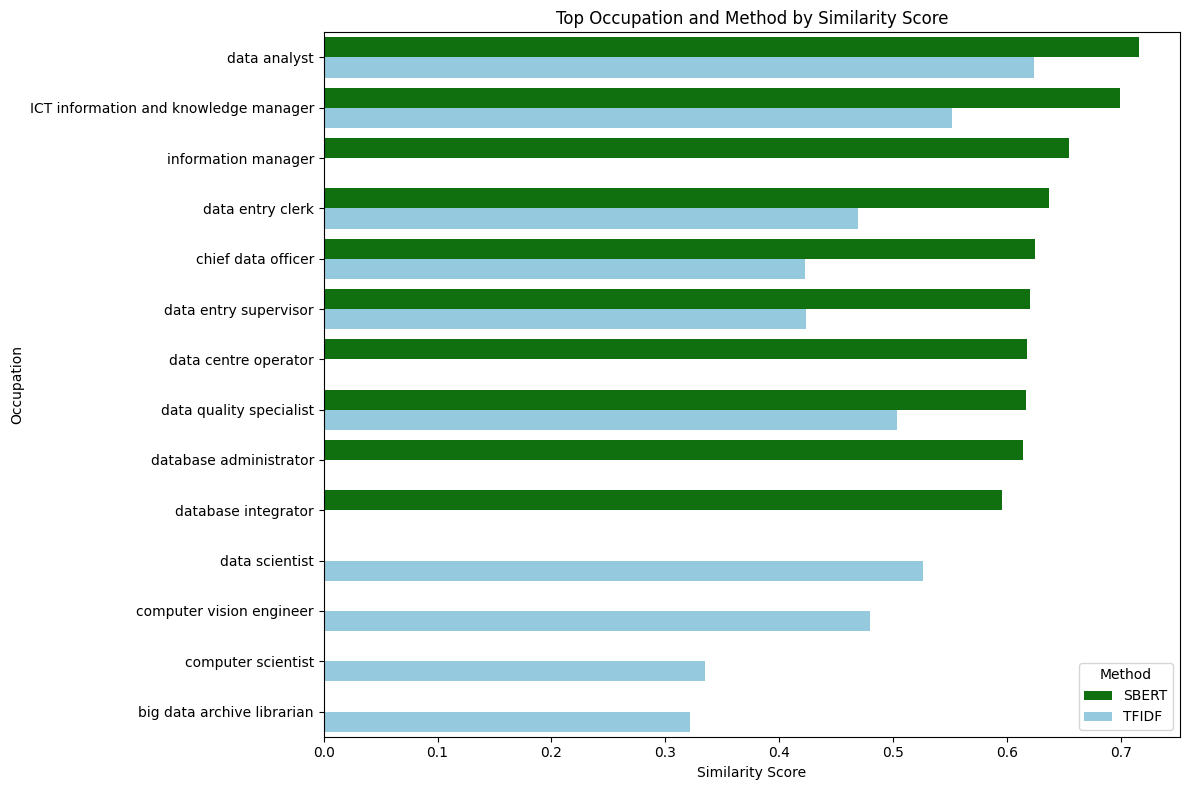

In [9]:
user_input = input("Please input the same skills as above: ")

recommended_occupations_tdif_output = recommend_occupations_tfidf(sort_list(user_input))
recommended_occupations_bert_output = recommend_occupations_bert(sort_list(user_input))

result = '''
        select * from (
            select *,'SBERT' as Method from recommended_occupations_bert_output
            union all 
            select *,'TFIDF' as Method from recommended_occupations_tdif_output
        ) order by Similarity desc
    '''
resultdata = psql.sqldf(result, locals())

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))
custom_palette = {"SBERT": "green", "TFIDF": "skyblue"}
# Create a barplot
sns.barplot(x='Similarity', y='Occupation', hue='Method', data=resultdata, palette=custom_palette, dodge=True)

# Add labels and title
plt.xlabel('Similarity Score')
plt.ylabel('Occupation')
plt.title('Top Occupation and Method by Similarity Score')
plt.legend(title='Method')

# Show the plot
plt.tight_layout()
plt.show()

The overlapping occupations in the results from both SBERT and TF-IDF methods demonstrate the robustness and complementary nature of these recommendation techniques in analyzing skill similarities across occupations. SBERT excels in capturing semantic relationships and understanding between skills, while TF-IDF effectively identifies occupations based on the prevalence and importance of specific technical skills and tools. Together, these methods provide a comprehensive view of occupations that align closely in terms of skill requirements and job roles, offering valuable insights for career planning, recruitment strategies, and skill development initiatives.

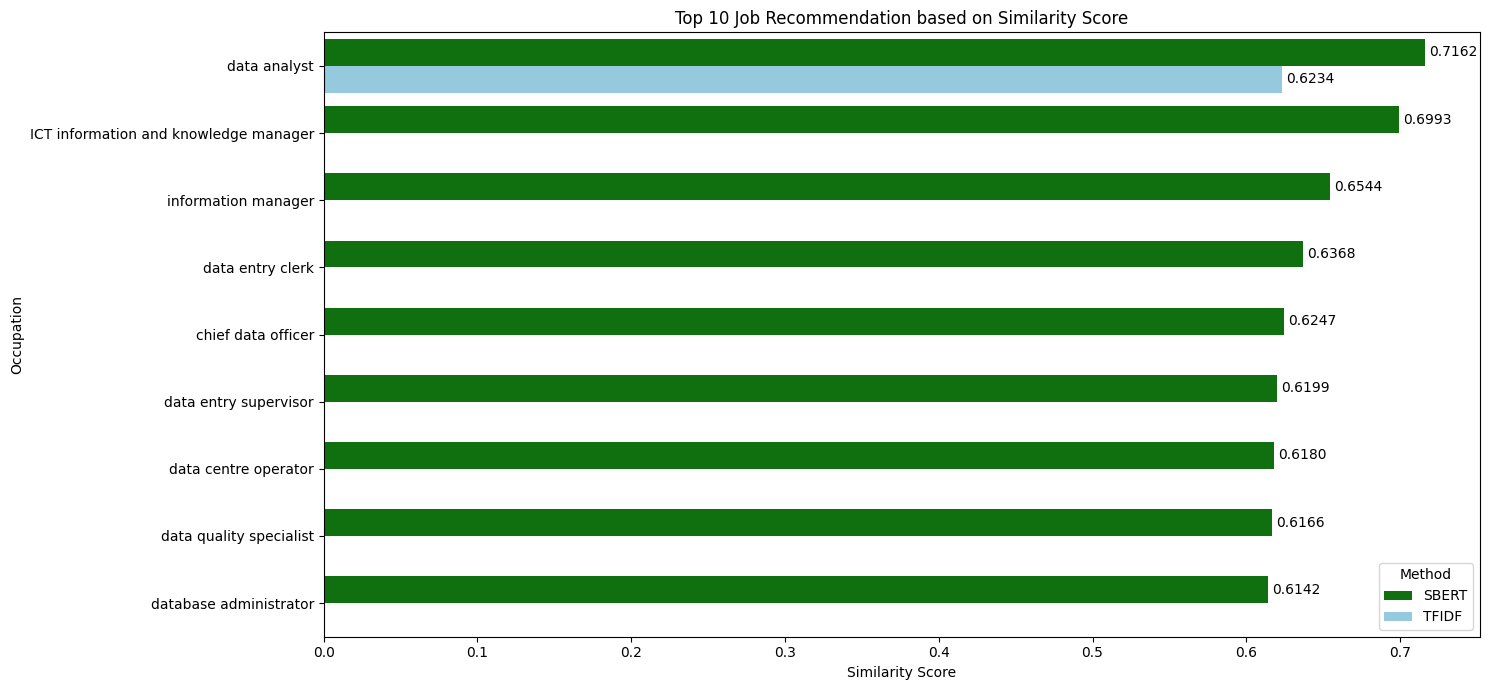

In [10]:
# Set up the matplotlib figure
plt.figure(figsize=(15, 7))
custom_palette = {"SBERT": "green", "TFIDF": "skyblue"}
# Create a clustered barplot
ax = sns.barplot(x='Similarity', y='Occupation', hue='Method', data=resultdata[:10], palette=custom_palette, dodge=True)

# Add labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f', padding=3)
    
# Add labels and title
plt.xlabel('Similarity Score')
plt.ylabel('Occupation')
plt.title('Top 10 Job Recommendation based on Similarity Score')
plt.legend(title='Method')

# Show the plot
plt.tight_layout()
plt.show()


### Conclusion

In occupation recommendation systems, SBERT consistently yields higher similarity scores than TF-IDF due to its advanced capability in capturing semantic relationships and contextual meanings within skill descriptions. SBERT encodes skill texts into dense vectors that preserve semantic similarities, allowing it to identify occupations that share subtle nuances in skill usage and application. This approach goes beyond simple keyword matching by considering the broader context and semantic closeness of skills, resulting in more nuanced and contextually relevant recommendations. 

In contrast, TF-IDF relies on statistical measures of keyword importance within occupations, which may overlook semantic nuances and result in lower similarity scores. Overall, SBERT's ability to handle varying skill descriptions and its focus on semantic understanding make it particularly effective for identifying closely related occupations based on skill similarities in recommendation systems.

The results provide insights into how different recommendation methods can highlight occupations based on varying aspects of skill similarity. 

Graduates can use these results to better understand which occupations align closely in terms of skills, helping in career planning, recruitment, and skill development strategies tailored to specific job markets and roles. Including occupations from both Level 2 and Level 4 in the results aims to offer graduates and users a broader perspective on career options. By showcasing occupations at different levels within the classification system, users can gain a comprehensive overview of relevant industries, enabling them to explore diverse career opportunities aligned with their skills and interests. This broader scope enhances decision-making by presenting a more expansive range of occupational choices for consideration and exploration.